# Baseline

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import utils.visualization_tb as vi
import utils.mining_data_tb as md

import warnings

warnings.filterwarnings("ignore")
sns.set_theme()

For convinience, I packed all the transformations from 0_analysis into functions

So, I'll just make use of it to load the ready-to-use data

It is quite likely that the test set doesn't have all the categories for some of the dummy variables, so I'll process train and test sets together and then work on them separetely

In [2]:
### Train data
train = pd.read_csv("data/train.csv", index_col = 0)
train_data, train_target = train.drop("SalePrice", axis = 1), train.loc[:, "SalePrice"]

### Test data
test_data = pd.read_csv("data/test.csv", index_col = 0)
# Ids to differentiate test data from train data
ids = test_data.index

In [3]:
# Now let's join the data
dataset = pd.concat([train_data, test_data], axis = 0)
dataset = md.ready_to_use(dataset)

# Finally, I split the data again between train data (to train the model)
# and test data (for the Kaggle submission)
train_data = dataset.drop(ids)
test_data = dataset.loc[ids, :]

## Linear Regression

For the regression I will start with a Linear Regression model as baseline and then start with some regularization.

In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_squared_log_error

Train scores:
[0.91942421 0.93290684 0.93652513 0.91623056 0.92039305]
Validation scores:
[0.85974533 0.22612913 0.76710059 0.88510026 0.84702059]


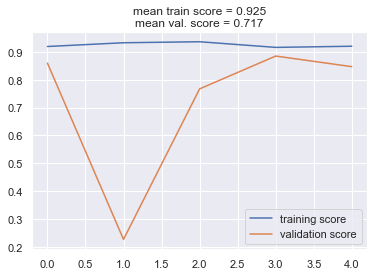

In [5]:
seed = 42

# Target and independent variables
X = np.array(train_data)
y = np.array(train_target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = seed)

# Model
lr = LinearRegression()

# Training
results = cross_validate(lr, X_train, y_train, cv = 5, n_jobs = -1, return_train_score = True)

# Show results
print(f"Train scores:\n{results['train_score']}")
print(f"Validation scores:\n{results['test_score']}")

plt.figure()
plt.title(f"mean train score = {round(np.mean(results['train_score']), 3)}\nmean val. score = {round(np.mean(results['test_score']), 3)}")
plt.plot(results["train_score"], label = "training score")
plt.plot(results["test_score"], label = "validation score")
plt.legend()
plt.show()

This is interesting and a bit unexpected. The model is overfitting in all folds, but for one, the difference between training and validation scores is huge.

It seems like the data in this fold is very different from the data in the rest of the sets.

I saw in 0_analysis plots that some of the variables had a more quadratic looking relationship with the target variable "SalePrice".

Let's use polynomialfeatures just to have a look at what it might look like.

## Polynomial Features

In [6]:
from sklearn.preprocessing import PolynomialFeatures

Train scores:
[1. 1. 1. 1. 1.]
Validation scores:
[ -1.15989845 -79.91208439  -7.54743264 -35.01576702  -2.94695933]


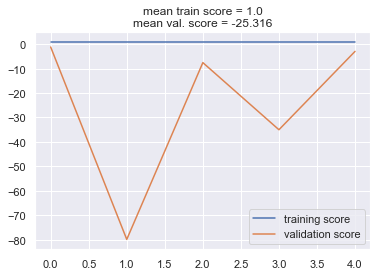

In [7]:
poly = PolynomialFeatures(degree = 2)

X_poly = poly.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state = seed)

# Model
lr = LinearRegression()

# Training
results = cross_validate(lr, X_train, y_train, cv = 5, n_jobs = -1, return_train_score = True)

# Show results
print(f"Train scores:\n{results['train_score']}")
print(f"Validation scores:\n{results['test_score']}")

plt.figure()
plt.title(f"mean train score = {round(np.mean(results['train_score']), 3)}\nmean val. score = {round(np.mean(results['test_score']), 3)}")
plt.plot(results["train_score"], label = "training score")
plt.plot(results["test_score"], label = "validation score")
plt.legend()
plt.show()

Well, this one clearly isn't a good option. Let's move forward with regularization.